In [1]:
import requests
import csv
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [38]:
class asset_info_collector:
  """
  Class to collect information about an asset via Api and web scraping
  """

  def __init__(self, symbol, api='demo'):
    """
    Initialize the main Attributes of the class
    """
    self._api = api #Store the api
    self.symbol_list = asset_info_collector.fetch_symbol_list(api) #Set a a sample list of the symbols
    self.symbol = symbol #Store the symbol
    self.time_series = None #Create two empty values for storage
    self.info = None
    self.fetch_time_series() #Fill the two empty values
    self.overview = None #Create empty values for storage
    self.fetch_overview() #Fill the empty value
    self.name = self.overview.loc['Name'].values[0] #Store the corresponding name from the symbol
    self.log_return = np.log(self.time_series['Close'].iloc[::-1]) - np.log(
      self.time_series['Close'].iloc[::-1].shift(1)) #Calculate and store the log return

  @staticmethod
  def fetch_symbol_list(api='demo'):  #SSee if names is preset!
    """
    Download of a example symbol list via API (callable without an object)
    """
    CSV_URL = f'https://www.alphavantage.co/query?function=LISTING_STATUS&apikey={api}'
    with requests.Session() as s:
      download = s.get(CSV_URL) #Donwload file
      decoded_content = download.content.decode('utf-8') #Decode File
      cr = csv.reader(decoded_content.splitlines(), delimiter=',') #Read csv file
      df_symbol = pd.DataFrame(cr) #Store it in a Dataframe
      df_symbol.columns = df_symbol.iloc[0] #Set column names
      df_symbol = df_symbol.loc[df_symbol['assetType'] == 'Stock'][1:].reset_index() #Sort table and only keep stocks
    return df_symbol

  @property  #Function if corresponding attribute is called
  def symbol(self): 
    return self._symbol

  @symbol.setter #Function if corresponding attribute is set
  def symbol(self, val): 
    if val not in self.symbol_list['symbol'].values: #Check if entered symbol is supported
      raise ValueError(
        'Please enter a valid symbol or take a look at the symbol list (asset_info_collector..fetch_symbol_list())'
      )  #Raise Error if it is not supportet
    self._symbol = val

  @property  #Function if corresponding attribute is called
  def api(self):
    return self._api

  def fetch_time_series(self):
    """
    Download of the corresponding time series data for the given symbol from Alpha Vantage
    """
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY&symbol={self.symbol}&apikey={self._api}'
    r = requests.get(url) #Get data
    data = r.json() #Read/decode data
    self.time_series = pd.DataFrame(data["Weekly Time Series"],
                                    dtype='float').T #Store data in Dataframe
    self.time_series.columns = ['Open', 'High', 'Low', 'Close', 'Volume'] #Set column names
    self.time_series.index = pd.to_datetime(self.time_series.index) #Transform index to datetime
    self.info_time_series = pd.DataFrame(data["Meta Data"],
                                         index=['Meta Data']).T #Store second table in Dataframe 
    
  def statistics(self):
    """
    Function which returns basic descriptive statistics from time series Dataframe
    """
    return self.time_series.describe(include='all')

  def fetch_overview(self):
    """
    Download of the corresponding general infos for the given symbol from Alpha Vantage
    """
    url = f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={self.symbol}&apikey={self._api}'
    r = requests.get(url) #Get data
    data = r.json() #Read/decode data
    self.overview = pd.DataFrame(data, index=['Data']).T #Store data in Dataframe 

  def income_statement(self, annual=False):
    """
    Download of the corresponding income statement for the given symbol from Alpha Vantage
    """
    url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={self.symbol}&apikey={self._api}'
    r = requests.get(url) #Get data
    data = r.json() #Read/decode data
    annual_reports = pd.DataFrame(data["annualReports"]) #Store data in Dataframe
    quarterly_reports = pd.DataFrame(data["quarterlyReports"]) #Store second table in Dataframe 
    if annual == True: #Check input value and return corresponding Dataframe
      return annual_reports
    else:
      return quarterly_reports

  def balace_sheet(self, annual=False):
    """
    Download of the corresponding balance sheet for the given symbol from Alpha Vantage
    """
    url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={self.symbol}&apikey={self._api}'
    r = requests.get(url) #Get data
    data = r.json() #Read/decode data
    annual_reports = pd.DataFrame(data["annualReports"]) #Store data in Dataframe
    quarterly_reports = pd.DataFrame(data["quarterlyReports"]) #Store second table in Dataframe 
    if annual == True: #Check input value and return corresponding Dataframe
      return annual_reports
    else:
      return quarterly_reports

  def cashflow(self, annual=False):
    """
    Download of the corresponding cashflow for the given symbol from Alpha Vantage
    """
    url = f'https://www.alphavantage.co/query?function=CASH_FLOW&symbol={self.symbol}&apikey={self._api}'
    r = requests.get(url) #Get data
    data = r.json() #Read/decode data
    annual_reports = pd.DataFrame(data["annualReports"]) #Store data in Dataframe
    quarterly_reports = pd.DataFrame(data["quarterlyReports"]) #Store second table in Dataframe 
    if annual == True: #Check input value and return corresponding Dataframe
      return annual_reports
    else:
      return quarterly_reports

  def earnings(self, annual=False):
    """
    Download of the corresponding earnings for the given symbol from Alpha Vantage
    """
    url = f'https://www.alphavantage.co/query?function=EARNINGS&symbol={self.symbol}&apikey={self._api}'
    r = requests.get(url) #Get data
    data = r.json() #Read/decode data
    annual_earnings = pd.DataFrame(data["annualEarnings"]) #Store data in Dataframe
    quarterly_earnings = pd.DataFrame(data["quarterlyEarnings"]) #Store second table in Dataframe 
    if annual == True: #Check input value and return corresponding Dataframe
      return annual_earnings
    else:
      return quarterly_earnings

  def current_news(self, key_val=None):
    """
    Function to get a list of links from marketnews for a given key word
    Default: it is searching for the symbol of the Stock or the name of the company
    """
    url = 'https://marketnews.com/'
    
    #Excess site
    request = requests.get(url, headers={'User-agent': 'Chrome/39.0.2171.95'})
    html = request.content
    soup = BeautifulSoup(html, 'lxml')
    
    #Check if key value is defined otherwise set it to the default keys
    if key_val == None:
      key_val = [self.symbol, self.name]
    
    #Create empty lists
    directory_list = []
    list_link = []
    
    #Check if a list or a string is given
    if type(key_val) == list:
      for key in key_val: #Iterate over list values
        directory = soup.findAll(
          'a',
          class_='widget__headline-text custom-post-headline',
          text=re.compile(key, re.IGNORECASE)) #Store individual resultts of the keys
        directory_list.extend(directory) #Add results to list
    else:
      directory_list = soup.findAll(
        'a',
        class_='widget__headline-text custom-post-headline',
        text=re.compile(key, re.IGNORECASE)) #Store results for string 
    
    #Check if there are multiple results or just one
    if type(directory_list) == list:
      for directory in directory_list: #Iterate over list values
        link = (directory.get('href')) #Get links
        print(link) #Print links
    else:
      link = (directory_list.get('href')) #Get link
      print(link) #Print link

  def plot_closing_price(self):
    """
    Function to plot the closing price
    """
    fig = sns.lineplot(
      data=self.time_series['Close'].iloc[::-1],
      color='darkblue').set(title=f'Closing Price {self.symbol}') #Define plot and set title
    plt.xlabel('Time') #Set x-label
    plt.ylabel('Closing Price') #Set y-label
    plt.show()

  def plot_log_return(self):
    """
    Function to plot the log return
    """
    fig = sns.lineplot(data=self.log_return,
                       color='darkblue').set(title=f'Log Return {self.symbol}') #Define plot and set title
    plt.xlabel('Time') #Set x-label
    plt.ylabel('Log Return') #Set y-label
    plt.show()

  def plot_volume(self):
    """
    Function to plot the volume
    """
    fig = sns.lineplot(data=self.time_series['Volume'].iloc[::-1],
                       color='darkblue').set(title=f'Volume {self.symbol}') #Define plot and set title
    plt.xlabel('Time') #Set x-label
    plt.ylabel('Volume') #Set y-label
    plt.show()

  def save(self, form='excel', name=None, path=''):
    """
    Function to export the time series table to an excel or csv file
    """
    #Check if name is defined otherwise set it to the default name
    if name == None:
      name = f'df_{self.symbol}'
    
    #Check input value and save it in corresponding file type
    if form == 'excel':
      path_name = path + name + '.xlsx' #combine path, name and type specific ending in string
      self.time_series.to_excel(path_name) #Save table in excel file
    elif form == 'csv':
      path_name = path + name + '.csv' #combine path, name and type specific ending in string
      self.time_series.to_csv(path_name) #Save table in csv file
    else:
      raise ValueError('Please choose a upported format (Excel or CSV)') #Raise error if other file type is past

### Showcase of functions

In [10]:
asset_info_collector.fetch_symbol_list()

,index,symbol,name,exchange,assetType,ipoDate,delistingDate,status
0,2,AA,Alcoa Corp,NYSE,Stock,2016-10-18,null,Active
1,5,AAC,Ares Acquisition Corporation - Class A,NYSE,Stock,2021-03-25,null,Active
2,6,AAC-U,Ares Acquisition Corporation - Units (1 Ord Sh...,NYSE,Stock,2021-02-02,null,Active
3,7,AAC-WS,Ares Acquisition Corporation - Warrants (01/01...,NYSE,Stock,2021-03-25,null,Active
4,8,AACG,ATA Creativity Global,NASDAQ,Stock,2008-01-29,null,Active
...,...,...,...,...,...,...,...,...
8994,12536,ZYNE,Zynerba Pharmaceuticals Inc,NASDAQ,Stock,2015-08-05,null,Active
8995,12537,ZYRX,Global Earnings Capital Ltd,NASDAQ,Stock,2007-07-13,null,Active
8996,12538,ZYXI,Zynex Inc,NASDAQ,Stock,2012-07-23,null,Active
8997,12539,ZZK,,NYSE ARCA,Stock,2020-07-22,null,Active


In [39]:
symbol = "IBM"
api = 'demo'

test = asset_info_collector(symbol, api)

In [15]:
test.time_series

,Open,High,Low,Close,Volume
2022-12-21,140.16,143.090,137.195,142.14,14233010.0
2022-12-16,147.82,153.210,138.970,140.16,33572382.0
2022-12-09,147.94,149.153,146.290,147.05,15316930.0
2022-12-02,147.98,150.010,145.670,148.67,20066941.0
2022-11-25,147.55,150.460,146.450,148.37,16271883.0
...,...,...,...,...,...
1999-12-10,113.00,122.120,107.560,109.00,58626000.0
1999-12-03,104.94,112.870,102.120,111.87,37670000.0
1999-11-26,105.50,109.870,101.810,105.00,37165600.0
1999-11-19,96.00,105.120,92.620,103.94,61550800.0


In [16]:
test.statistics()

,Open,High,Low,Close,Volume
count,1207.000000,1207.000000,1207.000000,1207.000000,1.207000e+03
mean,129.307525,132.243748,126.514139,129.411354,2.901812e+07
std,35.989018,36.158988,35.730011,35.978838,1.322902e+07
min,56.600000,62.000000,54.010000,56.600000,7.770697e+06
25%,98.015000,100.950000,95.650000,97.925000,1.923615e+07
50%,126.470000,128.940000,123.240000,126.640000,2.580147e+07
75%,153.375000,155.875000,151.035000,153.360000,3.534830e+07
max,212.900000,215.900000,210.110000,214.920000,1.108978e+08


In [19]:
test.overview

,Data
Symbol,IBM
AssetType,Common Stock
Name,International Business Machines
Description,International Business Machines Corporation (I...
CIK,51143
Exchange,NYSE
Currency,USD
Country,USA
Sector,TECHNOLOGY
Industry,COMPUTER & OFFICE EQUIPMENT


In [24]:
test.income_statement()

,fiscalDateEnding,reportedCurrency,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,...,depreciation,depreciationAndAmortization,incomeBeforeTax,incomeTaxExpense,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome
0,2022-09-30,USD,7430000000,14107000000,6677000000,57000000,1471000000,4391000000,1611000000,5959000000,...,586000000,577000000,-4483000000,-1287000000,295000000,-3214000000,1834000000,-4188000000,-3611000000,-3196000000
1,2022-06-30,USD,8290000000,15535000000,7246000000,120000000,2377000000,4855000000,1673000000,5913000000,...,620000000,626000000,1649000000,257000000,297000000,1465000000,1755000000,1946000000,2572000000,1392000000
2,2022-03-31,USD,7335000000,14197000000,6862000000,19000000,470000000,4597000000,1679000000,6865000000,...,631000000,625000000,694000000,-39000000,311000000,662000000,1436000000,1005000000,1630000000,733000000
3,2021-12-31,USD,6107000000,3257000000,-2849000000,89000000,913000000,3377000000,1581000000,5194000000,...,749000000,632000000,2092000000,-241000000,303000000,1301000000,5853000000,2395000000,3027000000,2333000000
4,2021-09-30,USD,7106000000,13251000000,6145000000,49000000,1761000000,4306000000,1606000000,6410000000,...,1037000000,647000000,1318000000,-224000000,291000000,1037000000,1480000000,1609000000,2256000000,1130000000
5,2021-06-30,USD,7852000000,14218000000,6366000000,103000000,2304000000,4849000000,1641000000,6700000000,...,1050000000,630000000,1426000000,101000000,281000000,810000000,1930000000,1707000000,2337000000,1325000000
6,2021-03-31,USD,7027000000,13187000000,6160000000,59000000,1084000000,4688000000,1616000000,7120000000,...,1052000000,620000000,795000000,-160000000,280000000,403000000,2036000000,1075000000,1695000000,955000000
7,2020-12-31,USD,5813000000,1926000000,-3888000000,181000000,-4000000000,4712000000,1540000000,2000000000,...,1089000000,610000000,884000000,-472000000,317000000,-305000000,603000000,1201000000,1811000000,1356000000
8,2020-09-30,USD,8430000000,17560000000,9130000000,64000000,2358000000,4647000000,1515000000,6072000000,...,1070000000,613000000,1826000000,128000000,323000000,1698000000,1870000000,2149000000,2762000000,1698000000
9,2020-06-30,USD,8700000000,18123000000,9423000000,117000000,2121000000,5248000000,1582000000,6579000000,...,1056000000,623000000,1570000000,209000000,323000000,1362000000,1888000000,1893000000,2516000000,1361000000


In [26]:
test.balace_sheet()

,fiscalDateEnding,reportedCurrency,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,...,depreciation,depreciationAndAmortization,incomeBeforeTax,incomeTaxExpense,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome
0,2022-09-30,USD,7430000000,14107000000,6677000000,57000000,1471000000,4391000000,1611000000,5959000000,...,586000000,577000000,-4483000000,-1287000000,295000000,-3214000000,1834000000,-4188000000,-3611000000,-3196000000
1,2022-06-30,USD,8290000000,15535000000,7246000000,120000000,2377000000,4855000000,1673000000,5913000000,...,620000000,626000000,1649000000,257000000,297000000,1465000000,1755000000,1946000000,2572000000,1392000000
2,2022-03-31,USD,7335000000,14197000000,6862000000,19000000,470000000,4597000000,1679000000,6865000000,...,631000000,625000000,694000000,-39000000,311000000,662000000,1436000000,1005000000,1630000000,733000000
3,2021-12-31,USD,6107000000,3257000000,-2849000000,89000000,913000000,3377000000,1581000000,5194000000,...,749000000,632000000,2092000000,-241000000,303000000,1301000000,5853000000,2395000000,3027000000,2333000000
4,2021-09-30,USD,7106000000,13251000000,6145000000,49000000,1761000000,4306000000,1606000000,6410000000,...,1037000000,647000000,1318000000,-224000000,291000000,1037000000,1480000000,1609000000,2256000000,1130000000
5,2021-06-30,USD,7852000000,14218000000,6366000000,103000000,2304000000,4849000000,1641000000,6700000000,...,1050000000,630000000,1426000000,101000000,281000000,810000000,1930000000,1707000000,2337000000,1325000000
6,2021-03-31,USD,7027000000,13187000000,6160000000,59000000,1084000000,4688000000,1616000000,7120000000,...,1052000000,620000000,795000000,-160000000,280000000,403000000,2036000000,1075000000,1695000000,955000000
7,2020-12-31,USD,5813000000,1926000000,-3888000000,181000000,-4000000000,4712000000,1540000000,2000000000,...,1089000000,610000000,884000000,-472000000,317000000,-305000000,603000000,1201000000,1811000000,1356000000
8,2020-09-30,USD,8430000000,17560000000,9130000000,64000000,2358000000,4647000000,1515000000,6072000000,...,1070000000,613000000,1826000000,128000000,323000000,1698000000,1870000000,2149000000,2762000000,1698000000
9,2020-06-30,USD,8700000000,18123000000,9423000000,117000000,2121000000,5248000000,1582000000,6579000000,...,1056000000,623000000,1570000000,209000000,323000000,1362000000,1888000000,1893000000,2516000000,1361000000


In [27]:
test.cashflow()

,fiscalDateEnding,reportedCurrency,operatingCashflow,paymentsForOperatingActivities,proceedsFromOperatingActivities,changeInOperatingLiabilities,changeInOperatingAssets,depreciationDepletionAndAmortization,capitalExpenditures,changeInReceivables,...,dividendPayoutCommonStock,dividendPayoutPreferredStock,proceedsFromIssuanceOfCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromIssuanceOfPreferredStock,proceedsFromRepurchaseOfEquity,proceedsFromSaleOfTreasuryStock,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome
0,2022-09-30,USD,1901000000,None,None,None,None,1163000000,317000000,None,...,1491000000,None,None,3395000000,None,-14000000,None,917000000,None,-3196000000
1,2022-06-30,USD,1321000000,None,None,None,None,1246000000,339000000,None,...,1488000000,None,None,318000000,None,0,None,-2703000000,None,1392000000
2,2022-03-31,USD,3248000000,None,None,None,None,1256000000,281000000,None,...,1475000000,None,None,4084000000,None,0,None,3267000000,None,733000000
3,2021-12-31,USD,2544000000,None,None,None,None,1381000000,450000000,1372000000,...,1474000000,None,None,128000000,None,0,None,-823000000,None,2333000000
4,2021-09-30,USD,2713000000,None,None,None,None,1684000000,558000000,None,...,1471000000,None,None,151000000,None,0,None,1130000000,None,1130000000
5,2021-06-30,USD,2625000000,None,None,None,None,1680000000,560000000,None,...,1467000000,None,None,192000000,None,0,None,1325000000,None,1325000000
6,2021-03-31,USD,4914000000,None,None,None,None,1672000000,494000000,None,...,1457000000,None,None,51000000,None,0,None,-2869000000,None,955000000
7,2020-12-31,USD,5860000000,None,None,None,None,1699000000,678000000,5297000000,...,1454000000,None,None,167000000,None,0,None,-4000000000,None,1356000000
8,2020-09-30,USD,4285000000,None,None,None,None,1683000000,725000000,None,...,1453000000,None,None,147000000,None,0,None,1698000000,None,1698000000
9,2020-06-30,USD,3576000000,None,None,None,None,1679000000,585000000,None,...,1450000000,None,None,4135000000,None,0,None,1361000000,None,1361000000


In [29]:
test.earnings()

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage
0,2022-09-30,2022-10-19,1.81,1.77,0.04,2.2599
1,2022-06-30,2022-07-18,2.31,2.27,0.04,1.7621
2,2022-03-31,2022-04-19,1.4,1.38,0.02,1.4493
3,2021-12-31,2022-01-24,3.35,3.3,0.05,1.5152
4,2021-09-30,2021-10-20,2.52,2.5,0.02,0.8
...,...,...,...,...,...,...
102,1997-03-31,1997-04-23,0.59,0.58,0.01,1.7241
103,1996-12-31,1997-01-21,0.98,0.99,-0.01,-1.0101
104,1996-09-30,1996-10-21,0.61,0.61,0,0
105,1996-06-30,1996-07-25,0.63,0.61,0.02,3.2787


In [40]:
test.current_news() #Mote the list is empty since there are now news

In [41]:
words=["china", "italy"]

test.current_news(words)

https://marketnews.com/mni-china-daily-summary-thursday-december-22
https://marketnews.com/mni-chinas-deficit-to-exceed-3-as-debt-grows-to-lift-growth
https://marketnews.com/australia-china-meeting-step-towards-improved-cooperation
https://marketnews.com/mni-china-daily-summary-thursday-december-22


In [37]:
test.overview.loc['Name'].values[0]

'International Business Machines'

In [6]:
word=["china", "italy"]
a.current_news(word)

https://marketnews.com/mni-china-daily-summary-thursday-december-22
https://marketnews.com/mni-chinas-deficit-to-exceed-3-as-debt-grows-to-lift-growth
https://marketnews.com/australia-china-meeting-step-towards-improved-cooperation
https://marketnews.com/mni-china-daily-summary-thursday-december-22


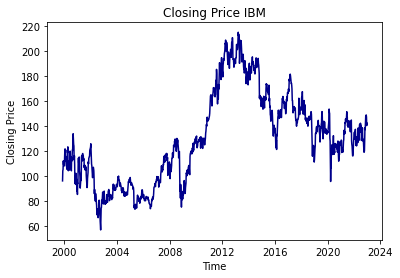

In [42]:
test.plot_closing_price()

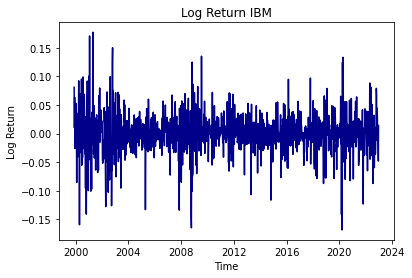

In [43]:
test.plot_log_return()

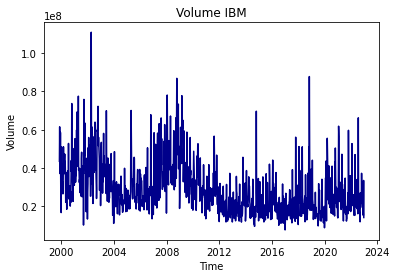

In [44]:
test.plot_volume()

In [45]:
test.save() 